### Use Monte Carlo to Price American Options

In this project you will implement your own option pricer using American Monte Carlo (Monte Carlo + Regression) Based on the method prescribed by Longstaff and Schwartz.


Basic Procedures follow that of Longstaff and Schwartz (2001)


Some code has been provided to you.  Your task is to:

1. Fill in the blanks where the code is missing <br>
2. Implement the following extension:<br>
  * Compare the prices for European and American options under different strikes with otherwise identical characteristics and describe/explain your observations in your report. 
  * Try with different number of basis functions (default is 6): 2,3,4,5,6,9,10,20. Plot the option prices against these different orders and observations in your report. 
  * (Optional) Consider the Heson stochastic volatility model below:
$d S_t = r S_t dt + \sqrt{V_t} S_t dW_t $,  where $ d V_t = \kappa( \theta - V_t) dt + \eta \sqrt{V_t} d B_t$, $d[W_t, B_t] = \rho dt$.  Modify the pricer accordingly and compare the option price with the constant volatility case. 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [ ]:
def sim_stock_price_GBM(S0, r, sigma, N_sim, N_T, dt):
        
    # Generate paths for underlying asset prices
    innovation = np.random.randn(N_sim, N_T)
    BM = np.zeros([N_sim, N_T+1])
    BM[:,0] = 0
    BM[:,1:] = innovation
    BM = np.cumsum(BM,axis=1)
    BM *= np.sqrt(dt)

    S = np.ones([N_sim, N_T+1])
    S[:,0] = 0
    S = S.cumsum(axis=1)
    S *= (r - 0.5*(sigma)**2)*dt
    S += sigma * BM
    S = S0*np.exp(S)
    
    return S

In [ ]:
def AMC(S0, K, r, sigma, N_sim, T, dt, N_basis=6, Filter_ITM=False, StockFrame=None):
    N_T = int(T/dt)
   
    # Simulate stock prices
    if StockFrame is None:
        S = sim_stock_price_GBM(S0, r, sigma, N_sim, N_T,dt)
    else: 
        S = StockFrame
        N_T = S.shape[1] - 1
        N_sim = S.shape[0]
    
    # Now backward induction & regression
    i = N_T
    print(S.shape)
    Cont = np.zeros(N_sim)  # This stores the continuation value. 
    cf = np.zeros((N_sim, N_T))
    cf[:,-1] = np.maximum(K-S[:,-1],0) # cash flow matrix
    stopping = np.zeros((N_sim, N_T),dtype=bool)  # stopping rule matrix
    stopping[:,-1] = (S[:,-1] < K) # last column: initialize to rue for in the money
    while i > 1:
        # First calculate option price
        # p = np.maximum(np.maximum(K-S[:,i],0),Cont)         
        x = S[:,i-1].copy()  # This is your predictive variable (x). In your prediction you need to use x, x^2, x^3,...x^N, where N = # of basis
        # select ITM paths 
        c = cf[:,i-1].copy()
        if Filter_ITM:  # take only ITM path for regression
            itm = (x < K)
            x = x[itm]
            c = c[itm]
            print(itm,x,c)
        # discounted option price
        y = np.exp(-r*dt)*c # This is your target variable (y)
        reg = np.poly1d(np.polyfit(x,y,N_basis))
        Cont = np.maximum(reg(x),0) 
        Exer = np.maximum(K-S[:,i-1],0)             
        stopping[:,i-2] = (Exer > Cont)
        stopping[:,i-1] = np.where(stopping[:,i-2],False,stopping[:,i-1])
        cf[:,i-2] = Exer * stopping[:,i-2] 
        cf[:,i-1] = np.where(stopping[:,i-2],0,cf[:,i-1])
        i = i - 1

    
    cf_disc = cf * np.exp(-r * np.arange(1,N_T+1))  # discount all cash flows
    return cf_disc.sum(axis=1).mean()

### Test using the example from Longstaff and Schwartz (2001)

In [ ]:
# Test
S0=1
K=1.1
r=0.06
sigma=0.3
N_sim=10
T=1
dt=1
price_path=np.array([[1,1,1,1,1,1,1,1],
                     [1.09,1.16,1.22,.93,1.11,.76,.92,.88],
                     [1.08,1.26,1.07,0.97,1.56,.77,.84,1.22],
                     [1.34,1.54,1.03,.92,1.52,.90,1.01,1.34]]).T

In [ ]:
AMC(S0,K,r,sigma, N_sim, T, dt, 2, False)

(10, 2)


0.09537786016180286

In [ ]:
S0=100
K=95
r=0.1
sigma=0.23
N_sim=10000
T=2
dt=0.5
AMC(S0,K,r,sigma, N_sim, T, dt)

(10000, 5)


4.717160791624501

## European Put price for comparison

In [ ]:
from scipy.stats import norm
def European_Put(S0,K,r,sigma,T):
    d1 = (np.log(S0/K) + (r + 0.5*(sigma)**2))*T/(sigma*np.sqrt(T)) 
    d2 = d1 - sigma*np.sqrt(T)
    return np.exp(-r*T)*K*norm.cdf(-d2) - S0*norm.cdf(-d1)

In [ ]:
S0=100
K=95
r=0.1
sigma=0.23
N_sim=10000
T=2
dt=0.5
AMC(S0,K,r,sigma, N_sim, T, dt)

(10000, 5)


4.620355799576784

In [ ]:
European_Put(S0,K,r,sigma,T)

3.494842856345061

In [ ]:
def AMC_S(S):
    return AMC(S,K,r,sigma,N_sim,T,dt)

## Compare European and American Option prices under different underlying stock prices

(10000, 5)
(10000, 5)
(10000, 5)
(10000, 5)
(10000, 5)
(10000, 5)
(10000, 5)


Text(0, 0.5, 'Put Price')

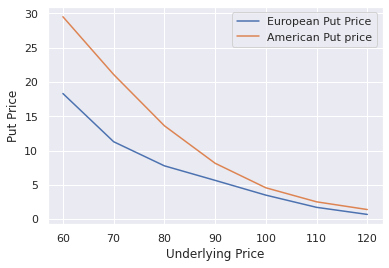

In [ ]:
S= [60,70,80,90,100,110,120]
option_Eur = [European_Put(ss,K,r,sigma,T) for ss in S ]
option_Am = [AMC_S(ss) for ss in S]
plt.plot(S, option_Eur, label='European Put Price')
plt.plot(S, option_Am, label='American Put price')
plt.legend()
plt.xlabel('Underlying Price')
plt.ylabel('Put Price')

## Compare American option prices under different number of basis

(10, 2)
(10, 2)
(10, 2)
(10, 2)
(10, 2)
(10, 2)
(10, 2)
(10, 2)
(10, 2)
(10, 2)
(10, 2)


Text(0, 0.5, 'Option price')

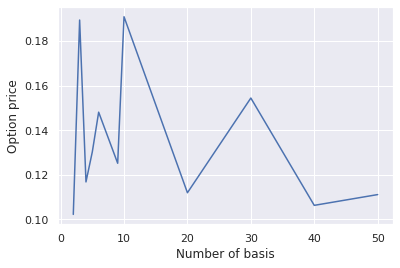

In [ ]:
num_basis = [2,3,4,5,6,9,10,20,30,40,50]
option_prices=[]
for num in num_basis:
    c=AMC(S0,K,r,sigma, N_sim, T, dt,num)
    option_prices.append(c)
plt.plot(num_basis, option_prices)
plt.xlabel('Number of basis')
plt.ylabel('Option price')

In [ ]:
from ipywidgets import interact
import ipywidgets as widgets
interact(AMC_S, S=widgets.FloatSlider(min=50, max=120, step=5))

interactive(children=(FloatSlider(value=50.0, description='S', max=120.0, min=50.0, step=5.0), Output()), _dom…

<function __main__.AMC_S>

# Heston Model for stock simulation

In [ ]:
def sim_stock_hest(t0,T,S0,V0,N_t,r,kappa,theta, eta, rho, N_sim):
    dt = T/N_t
    t = np.linspace(t0,T,N_t+1)
    sdt = np.sqrt(dt)
    
    Z1 = np.random.randn(N_sim, N_t)
    Z2 = np.random.randn(N_sim, N_t)
    Z3 = rho*Z1 + np.sqrt(1-rho**2)*Z2
    
    S = np.zeros((N_sim, N_t+1))
    S[:,0] = S0
    
    V = np.zeros((N_sim, N_t+1))
    V[:,0] = V0

    for i in range(N_t):
        vol = np.sqrt(np.maximum(V[:,i],0))
        S[:,i+1] = S[:,i] + r*S[:,i]*dt + vol*S[:,i]*sdt*Z1[:,i] + 0.5*V[:,i]*S[:,i]*(Z1[:,i]**2 - 1)*dt
        V[:,i+1] = V[:,i] + kappa*(theta - V[:,i])*dt + eta*vol*sdt*Z3[:,i] + 0.25*(eta**2)*(Z3[:,i]**2 - 1)*dt
    return S
                      

In [ ]:
# Use Heston model to price American Options

In [ ]:
def AMC_Heston(S0,K,r,N_sim, T, dt, V0, kappa, theta, eta, rho, N_basis=6, Filter_ITM=True):
    N_T = int(T/dt)
   
    # Simulate stock prices 
    S = sim_stock_hest(0,T,S0,V0,N_T,r,kappa,theta, eta, rho, N_sim)
    print(S.shape)
    # Now backward induction & regression
    i = N_T
    
    Cont = np.zeros(N_sim)  # This stores the continuation value. 
    cf = np.zeros((N_sim, N_T))
    cf[:,-1] = np.maximum(K-S[:,-1],0) # cash flow matrix
    stopping = np.zeros((N_sim, N_T),dtype=bool)  # stopping rule matrix
    stopping[:,-1] = (S[:,-1] < K) # last column: initialize to rue for in the money
    while i > 1:
        # First calculate option price
        # p = np.maximum(np.maximum(K-S[:,i],0),Cont)       
        x = S[:,i-1].copy()  # This is your predictive variable (x). In your prediction you need to use x, x^2, x^3,...x^N, where N = # of basis
        # select ITM paths 
        c = cf[:,i-1].copy()
        if Filter_ITM:
            itm = (x < K)
            x = x[itm]
            c = c[itm]
        # discounted option price
        y = np.exp(-r*dt)*c # This is your target variable (y)
        reg = np.poly1d(np.polyfit(x,y,N_basis)) 
        Cont = np.maximum(reg(S[:,i-1]),0) 
        Exer = np.maximum(K-S[:,i-1],0)             
        stopping[:,i-2] = (Exer > Cont)
        stopping[:,i-1] = np.where(stopping[:,i-2],False, stopping[:,i-1])
        cf[:,i-2] = np.where(Exer > Cont, Exer, 0)
        cf[:,i-1] = np.where(stopping[:,i-2], 0, cf[:,i-1])
        i = i - 1

    #print(cf)
    cf_disc = cf * np.exp(-r * np.arange(1,N_T+1))
    #print(cf_disc)
    return np.mean(np.sum(cf_disc,axis=1))


In [ ]:
S0=100
K=95
V0=0.0529
T=2
dt=0.01
r=0.1
kappa=0.5
theta=0.0529
eta=0.23
rho=-0.9
N_sim=10000

In [ ]:
AMC_Heston(S0,K,r,N_sim, T, dt, V0, kappa, theta, eta, rho,6,False)

(20000, 201)


1.7862294674933008

(10000, 201)
(10000, 201)
(10000, 201)
(10000, 201)
(10000, 201)
(10000, 201)
(10000, 201)
(10000, 201)


Text(0, 0.5, 'Put Price')

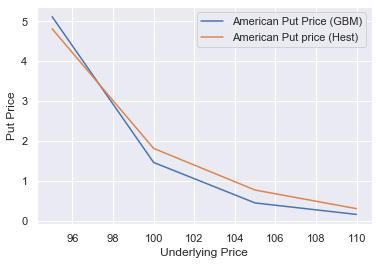

In [ ]:
S= [95,100,105,110]
option_GBM = [AMC(ss,K,r,sigma, N_sim, T, dt, 6,False) for ss in S]
option_Hest = [AMC_Heston(ss,K,r,N_sim, T, dt, V0, kappa, theta, eta, rho,6,False) for ss in S]
plt.plot(S, option_GBM, label='American Put Price (GBM)')
plt.plot(S, option_Hest, label='American Put price (Hest)')
plt.legend()
plt.xlabel('Underlying Price')
plt.ylabel('Put Price')